In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from researchai.layers import Dense
from researchai.commons import Softmax_CategoricalCrossentropy
from researchai.metrics import classification_accuracy
from researchai.activations import Softmax
from researchai.optimizers import SGD
from researchai.utils import one_hot

In [2]:
data_path = Path("../data")

In [3]:
df = pd.read_csv(data_path / "names.txt", names=["Name"])
df.head(10)

,Name
0,emma
1,olivia
2,ava
3,isabella
4,sophia
5,charlotte
6,mia
7,amelia
8,harper
9,evelyn


In [4]:
df.describe()

,Name
count,32033
unique,29494
top,emma
freq,2


In [5]:
# We have some duplicates 
df['Name'] = df['Name'].str.lower()
df.drop_duplicates(subset=['Name'], keep='first', inplace=True)

df.describe()

,Name
count,29494
unique,29494
top,emma
freq,1


In [6]:
df.head(10)

,Name
0,emma
1,olivia
2,ava
3,isabella
4,sophia
5,charlotte
6,mia
7,amelia
8,harper
9,evelyn


## mininum and maximum length of the words

In [7]:
df["Length"] = df["Name"].apply(lambda s: len(s))
df.head(10)

,Name,Length
0,emma,4
1,olivia,6
2,ava,3
3,isabella,8
4,sophia,6
5,charlotte,9
6,mia,3
7,amelia,6
8,harper,6
9,evelyn,6


In [8]:
df.sort_values(by=["Length"], ascending=False)

,Name,Length
31441,muhammadibrahim,15
31442,muhammadmustafa,15
30197,alexanderjames,14
29637,michaelanthony,14
12005,mariaguadalupe,14
...,...,...
24160,jd,2
10930,kc,2
24159,jc,2
23151,dj,2


# Probabilistic model

In [9]:
trigrams = {}
for word in df["Name"]:
    chars = ['<S>'] + list(word) + ['<E>']
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        trigram = (char1+char2, char3)
        trigrams[trigram] = trigrams.get(trigram, 0) + 1

In [10]:
sorted(trigrams.items(), key=lambda kv: -kv[1])

[(('na', '<E>'), 1650),
 (('ah', '<E>'), 1637),
 (('<S>m', 'a'), 1373),
 (('on', '<E>'), 1365),
 (('an', '<E>'), 1344),
 (('<S>j', 'a'), 1161),
 (('<S>k', 'a'), 1144),
 (('en', '<E>'), 1055),
 (('ly', 'n'), 899),
 (('ia', '<E>'), 883),
 (('ar', 'i'), 854),
 (('yn', '<E>'), 803),
 (('an', 'n'), 800),
 (('ie', '<E>'), 789),
 (('el', 'l'), 788),
 (('an', 'a'), 787),
 (('ia', 'n'), 752),
 (('ma', 'r'), 723),
 (('ya', '<E>'), 702),
 (('in', '<E>'), 672),
 (('la', '<E>'), 669),
 (('el', '<E>'), 668),
 (('an', 'i'), 654),
 (('iy', 'a'), 649),
 (('<S>d', 'a'), 646),
 (('nn', 'a'), 624),
 (('ra', '<E>'), 612),
 (('<S>a', 'l'), 606),
 (('<S>a', 'n'), 599),
 (('er', '<E>'), 587),
 (('nn', '<E>'), 583),
 (('al', 'e'), 579),
 (('la', 'n'), 574),
 (('ne', '<E>'), 572),
 (('<S>c', 'a'), 564),
 (('<S>b', 'r'), 561),
 (('<S>s', 'a'), 560),
 (('al', 'i'), 556),
 (('ee', '<E>'), 556),
 (('ni', '<E>'), 553),
 (('<S>k', 'e'), 548),
 (('sh', 'a'), 539),
 (('el', 'i'), 512),
 (('li', 'a'), 501),
 (('ya', 'h'

In [11]:
# Loop up tables 
chars = sorted(set("".join(df["Name"].to_list()))) + ['<S>'] + ['<E>']

stoi = {char:i for i, char in enumerate(chars)}
itos = {i:chars for chars, i in stoi.items()}
itos

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: '<S>',
 27: '<E>'}

In [12]:
counts_array = np.zeros((28, 28, 28), dtype=np.int64) + 1 # model smoothing

for word in df["Name"]:
    chars = ['<S>'] + list(word) + ['<E>']
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        idx3 = stoi[char3]

        counts_array[idx1, idx2, idx3] += 1

In [13]:
counts_array[stoi["h"], stoi["n"], stoi["a"]]

41

In [14]:
# probability_matrix = np.full_like(probability_matrix, fill_value=1/27)
probability_matrix = counts_array / counts_array.sum(axis=-1, keepdims=True) # probabilistic model

In [15]:
pretty_print = True
for i in range(20):
    idx1, idx2 = 26, 26
    chars = []
    while True:
        probs = probability_matrix[idx1, idx2]
        chars.append(itos[idx2])
        if idx2 == 27:
            break
        idx1 = idx2 # move forward by one position
        idx2 = np.random.multinomial(1, probs).argmax()

    if pretty_print:
        print("".join(chars[1:-1]))
    else:
        print(''.join(chars))

trie
kylessep<S>farsendrahi
erezeat
tetut<S>sale
ummanymhelynna
yon
milyn
olenlyn
ni
zimutlana
walia
iona
lan
fael
prirel
okquarik
<S>owylamateig<S>menzgri
zaddamerriarpin
mi
<S>bazfnrannaymay


In [16]:
loss = 0.0
num_samples = 0
for w in df["Name"]:
    chars = ['<S>'] + list(w) + ['<E>']
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        idx3 = stoi[char3]

        probability = probability_matrix[idx1, idx2, idx3]
        loss += -np.log(probability)
        num_samples += 1

# Normilize loss
loss = loss / num_samples
print(f"Train loss: {loss:.3f}")

Train loss: 2.102


# Neural Network approch

In [17]:
X, y = [], []
for w in df["Name"]:
    chars = ['<S>'] + list(w) + ['<E>']
    for char1, char2, char3 in zip(chars, chars[1:], chars[2:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        idx3 = stoi[char3]

        X.append((idx1, idx2))
        y.append(idx3)

X = np.array(X)
y = np.array(y)

In [18]:
X1 = one_hot(X[:, 0], num_classes=28)
X2 = one_hot(X[:, 1], num_classes=28)

X = np.hstack((X1, X2))
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
layer1 = Dense(28*2, 28)
softmax_cross_entropy = Softmax_CategoricalCrossentropy()

optimizer = SGD()

losses = []
accuracies = []
for epoch in range(1, 101):
    # forward
    layer1.forward(X)
    softmax_cross_entropy.forward(layer1.outputs, y)

    loss = softmax_cross_entropy.loss
    acc = classification_accuracy(softmax_cross_entropy.outputs, y)

    # stats
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.3f}, Acc: {acc:.3f}")

    # log
    losses.append(loss)
    accuracies.append(acc)

    # early stopping
    if loss <= 2.454:
        print("Early Stopping, reached desired loss.")
        break

    # backward
    softmax_cross_entropy.backward()
    layer1.backward(softmax_cross_entropy.inputs_grad)

    # update params
    optimizer.step(layer1)


Epoch: 10, Loss: 2.914, Acc: 0.222
Epoch: 20, Loss: 2.742, Acc: 0.229
Epoch: 30, Loss: 2.664, Acc: 0.234
Epoch: 40, Loss: 2.616, Acc: 0.234
Epoch: 50, Loss: 2.582, Acc: 0.242
Epoch: 60, Loss: 2.557, Acc: 0.250
Epoch: 70, Loss: 2.536, Acc: 0.251
Epoch: 80, Loss: 2.518, Acc: 0.256
Epoch: 90, Loss: 2.504, Acc: 0.257
Epoch: 100, Loss: 2.491, Acc: 0.260


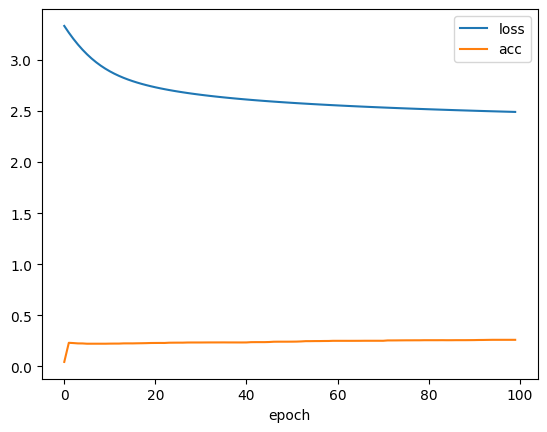

In [20]:
plt.plot(losses, label='loss')
plt.plot(accuracies, label='acc')
plt.xlabel("epoch")

plt.legend()
plt.show()

In [23]:
# Sample from neural network model
softmax = Softmax()

pretty_print = True
for i in range(20):
    idx1, idx2 = 26, 26
    chars = []
    while True:
        # forward
        in1 = one_hot(np.array([idx1]), num_classes=28)
        in2 = one_hot(np.array([idx2]), num_classes=28)
        inputs = np.hstack((in1, in2)).reshape(-1)

        layer1.forward(inputs)
        softmax.forward(layer1.outputs)
        
        probs = softmax.outputs

        chars.append(itos[idx2])
        if idx2 == 27:
            break
        
        idx1 = idx2 # move forward by one position
        idx2 = np.random.multinomial(1, probs).argmax()

    if pretty_print:
        print("".join(chars[1:-1]))
    else:
        print(''.join(chars))

otan
aav<S>lan
nlyng
r
iaral
a
edyc
ahivti
alye
le
yelesrna
loerr
are
onaiem
aealaiy
hhaa

ahon
jwedhltbon
aroheyeh


## Well at least the loss has improved from 2.454 to 2.102 by using a trigram-model